In [56]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime
import pandas as pd
import geopandas as gpd
import osmpy
from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
import shapely

cm = str(datetime.today().strftime("%Y%m%d%H%m"))

In [82]:
# EJEMPLO
# polygon = [(4.0, -2.0), (5.0, -2.0), (4.0, -3.0), (3.0, -3.0), (4.0, -2.0)]
# shapely_poly = shapely.geometry.Polygon(polygon)
# 
# line = [(4.0, -2.0000000000000004), (2.0, -1.1102230246251565e-15)]
# shapely_line = shapely.geometry.LineString(line)
# 
# intersection_line = list(shapely_poly.intersection(shapely_line).coords)
# print(intersection_line)
# #shapely_poly.intersection(shapely_line)
# shapely_poly.intersection(shapely_line).is_empty

[(4.0, -2.0000000000000004)]


False

In [152]:
conn = utils.connect_athena(path='../configs/athena.yaml')
qry = f"""
    select distinct line_wkt
    from spd_sdv_waze_corona.raw_copy_jams"""
# df_lines = pd.read_sql_query(qry, conn)
# df_lines.to_csv('/home/soniame/private/line_wkt_202010701.csv')
print(df_lines.shape)
df_lines.line_wkt.head()

../src/utils.py:159: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  athena_config = yaml.load(open(path, "r"))


(1175153, 1)


0    LINESTRING(-58.373466 -34.61024, -58.372053 -3...
1    LINESTRING(-54.345238 -34.494133, -54.346139 -...
2    LINESTRING(-35.198845 -5.855827, -35.199177 -5...
3    LINESTRING(-38.334909 -10.370219, -38.328788 -...
4    LINESTRING(-58.734996 -34.506163, -58.733279 -...
Name: line_wkt, dtype: object

1175153

5970.269755


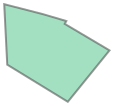

In [173]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
geometry

In [176]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

def intersection_func(line, geometry):
    line_wkt = wkt.loads(line)
    result = geometry.intersection(line_wkt).is_empty == False
    return(int(result))

def threshold_density_func(geometry, threshold_value):
    """Compares the threshold values with the number of lines"""
    
    print('Running')
    
    times = [intersection_func(line, geometry) for line in df_lines.line_wkt]
    intersection = sum(times)
    total = len(times)
    
    print(intersection)
    print(total)
    print(intersection/total)
    
    return (intersection/total) < (threshold_value/total)

In [ ]:

times = [intersection_func(line, geometry) for line in df_lines.line_wkt]
intersection = sum(times)
total = len(times)

print(intersection)
print(total)
print(intersection/total)



In [158]:
result = osmpy.core.katana(geometry, 
                           threshold_func = threshold_density_func, 
                           threshold_value = 110000, 
                           count = 100)

Running
0
1175153


NameError: name 'interesection' is not defined

In [137]:
result

INFO|%|s


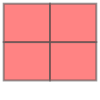

In [138]:
multipolygon = MultiPolygon(result)
multipolygon

INFO|%|s


4


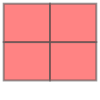

In [139]:
print(len(MultiPolygon(result).geoms))
multipolygon

In [8]:
grid = list()
for polygon in MultiPolygon(result):  # same for multipolygon.geoms
    grid.append(str(polygon))

In [17]:
outdf = gpd.GeoDataFrame(columns=['geometry'])
outdf['geometry'] = grid
outdf.to_csv(f"~/private/projects/geo_grid_area_{cm}.csv")